### Cab-Driver Agent

In [1]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Nadam

# for plotting graphs
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [((0, 12, 1), (1, 4)), ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3)), ((3, 18, 5), (3, 4))]

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
import pandas as pd
def convert_to_data_frame(model_name, data):
    df = pd.DataFrame.from_records(data)
    df['name'] = model_name
    return df

In [7]:
from itertools import product

hp_learning_rate = [0.001, 0.002]
hp_gamma = [0.95]
decay_rate = [0.0003, 0.0005]
layers = [[32, 32], [64, 64], [128, 128]]

hp_params = list(product(hp_learning_rate, hp_gamma, decay_rate, layers))

In [8]:
def plot_tracked_values(states_tracks, big=False):
    if big:
        row = 2
        column = 2
        figsize = (16, 12)
    else:
        row = 1
        column = 4
        figsize = (16, 4)

    fig, axs = plt.subplots(row, column, figsize=figsize)
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(states_tracks[tracked_value[0]][tracked_value[1]])))
        plt.subplot(row, column, index + 1)
        plt.plot(xaxis,
                 np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]))
        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
    plt.show()

In [9]:
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [10]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [11]:
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [12]:
class DQNAgent:
    def __init__(self, agent_param, state_encoder):
        agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space

        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        self.batch_size = agent_param.batch_size
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        self.epsilon = 1

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Nadam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                # print(True)
                target[index][actions[index]] = rewards[index]

            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [13]:
env = CabDriver()

In [14]:
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

### DQN block

In [15]:
def q_learning(agent_param,
               max_epsilon=1.0,
               episodes=50000,
               verbose=False,
               name='dqn_agent_state_as_input_arch'):

    log_threshold = episodes * .001
    threshold = episodes * .001
    model_threshold = episodes * 0.01

    print("number of episodes", episodes)
    print("log_threshold", log_threshold)
    print("threshold", threshold)
    print("model_threshold", model_threshold)

    start_time = time.time()

    agent = DQNAgent(agent_param=agent_param, state_encoder=state_encoder)

    total_rewards = []
    for episode in range(episodes):

        # tracking total rewards, step count
        total_reward = 0

        state = env.reset()[2]
        is_finished = False

        current_episode = episode + 1

        while not is_finished:

            action = agent.get_action(state, episode, env.get_requests(state))

            reward = env.get_reward(state, action, Time_matrix)

            next_state, is_finished, episode_time_till_now = env.get_next_state(
                state, action, Time_matrix)

            agent.save_experience(state, action, reward, next_state,
                                  is_finished)

            # every time step do the training
            agent.train_model()
            total_reward += reward
            state = next_state

            # Store the rewards
            if is_finished and current_episode % log_threshold == 0:
                total_rewards.append(total_reward)
                if verbose:
                    print(
                        "episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                        .format(current_episode, total_reward,
                                agent.memory_length(), episode_time_till_now,
                                agent.epsilon))

        if (current_episode % model_threshold) == 0:
            print("saving model for episode ", current_episode)
            agent.save("./" + name + "_dqn_cab_driver.h5")

        if (current_episode % threshold) == 0:
            agent.update_tracking_states()

    elapsed_time = time.time() - start_time
    print("elapsed_time {} minutes".format(round(elapsed_time / 60, 2)))

    return agent, total_rewards

In [16]:
stats = None

In [17]:
def collect_stats(df):
    global stats
    if stats is not None:
        stats = pd.concat([stats, df], axis=0)
    else:
        stats = df
    return df

In [18]:
EPISODES = 15000
agent_param_dict = {
    "action_size": len(env.action_space),
    "state_size": env.state_size,
    "action_space": env.action_space,
    "epsilon_max": 1.0,
    "epsilon_min": 0.000001,
    "epsilon_decay": 0.0005,
    "discount_factor": 0.95,
    "batch_size": 32,
    "layers": [32, 32],
    "learning_rate": 0.001
}

agent_param = AgentParam(agent_param_dict)

agent, total_rewards = q_learning(agent_param=agent_param,
                                  episodes=EPISODES,
                                  verbose=True,
                                  name="dqn_agent_state_as_input_arch_32_32")

number of episodes 15000
log_threshold 15.0
threshold 15.0
model_threshold 150.0
Agent Params: 
********************************************************
learning_rate -> 0.001
action_size -> 21
state_size -> 36
action_space -> [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3]]
epsilon_max -> 1.0
epsilon_min -> 1e-06
epsilon_decay -> 0.0005
discount_factor -> 0.95
batch_size -> 32
layers -> [32, 32]
********************************************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense

episode: 945, rewards: 360.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.6237538891642391
episode: 960, rewards: 608.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.61909324177
episode: 975, rewards: 115.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.6144674184775979
episode: 990, rewards: 800.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.6098761590832529
episode: 1005, rewards: 346.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.6053192053274137
episode: 1020, rewards: -95.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.6007963008802296
episode: 1035, rewards: 584.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5963071913271334
episode: 1050, rewards: 324.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5918516241545286
saving model for episode  1050
episode: 1065, rewards: 200.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5874293487355873
episode: 1080, rewards: 

episode: 2085, rewards: 1138.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.35274912628471006
episode: 2100, rewards: 473.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.35011341162245907
saving model for episode  2100
episode: 2115, rewards: 954.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.3474973908756768
episode: 2130, rewards: 850.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3449009168925065
episode: 2145, rewards: 702.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.342323843620602
episode: 2160, rewards: 814.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.33976602609891216
episode: 2175, rewards: 937.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.33722732044952713
episode: 2190, rewards: 1019.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3347075838695846
episode: 2205, rewards: 904.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.3322066746232376
episode: 2

episode: 3210, rewards: 1423.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.20099082381304245
episode: 3225, rewards: 940.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.19948903886760036
episode: 3240, rewards: 775.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1979984751769441
episode: 3255, rewards: 954.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.19651904889647295
episode: 3270, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.19505067680806865
episode: 3285, rewards: 675.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.19359327631541398
episode: 3300, rewards: 1304.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.19214676543934703
saving model for episode  3300
episode: 3315, rewards: 1147.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.1907110628132495
episode: 3330, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.18928608767847024
epi

episode: 4335, rewards: 1451.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.11452154955436585
episode: 4350, rewards: 1030.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.1136658582860135
saving model for episode  4350
episode: 4365, rewards: 940.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.11281656069591003
episode: 4380, rewards: 1268.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.111973609010842
episode: 4395, rewards: 1277.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.11113695581455495
episode: 4410, rewards: 972.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.11030655404508596
episode: 4425, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10948235699211649
episode: 4440, rewards: 1098.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.10866431829434507
episode: 4455, rewards: 1259.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.10785239193687923
ep

episode: 5445, rewards: 1034.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.06574407083613332
episode: 5460, rewards: 1286.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.0652528422148242
episode: 5475, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06476528402684484
episode: 5490, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06428136884691851
episode: 5505, rewards: 1121.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.06380106945468875
episode: 5520, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06332435883318817
episode: 5535, rewards: 1719.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.06285121016731858
episode: 5550, rewards: 1461.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.06238159684234272
saving model for episode  5550
episode: 5565, rewards: 1631.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0619154924423873

episode: 6555, rewards: 1285.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.037742273332896516
episode: 6570, rewards: 1575.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03746027260749721
episode: 6585, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03718037897605903
episode: 6600, rewards: 1276.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.03690257669449144
saving model for episode  6600
episode: 6615, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.036626850136342856
episode: 6630, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.03635318379192164
episode: 6645, rewards: 1218.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0360815622674238
episode: 6660, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.03581197028406695
episode: 6675, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.03554439267723

episode: 7665, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.021667218122648654
episode: 7680, rewards: 1341.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.021505329328559634
episode: 7695, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02134465015866545
episode: 7710, rewards: 1560.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.021185171574720406
episode: 7725, rewards: 1601.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.021026884606012135
episode: 7740, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.020869780348856892
episode: 7755, rewards: 1623.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.020713849966098787
episode: 7770, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02055908468661269
episode: 7785, rewards: 1756.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.02040547580481081
episode: 7800, rewards

episode: 8775, rewards: 1476.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012438974829244111
episode: 8790, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012346038963159068
episode: 8805, rewards: 1678.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012253797508770741
episode: 8820, rewards: 1476.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012162245277473007
episode: 8835, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012071377119428723
episode: 8850, rewards: 1525.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.011981187923280023
saving model for episode  8850
episode: 8865, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01189167261586085
episode: 8880, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011802826161911575
episode: 8895, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.01171464

episode: 9885, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007141296334928524
episode: 9900, rewards: 999.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007087944432138829
saving model for episode  9900
episode: 9915, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0070349911718420805
episode: 9930, rewards: 1398.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.00698243357540341
episode: 9945, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.006930268686444167
episode: 9960, rewards: 1354.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.0068784935706756
episode: 9975, rewards: 1182.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.006827105315733782
episode: 9990, rewards: 1683.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006776101031015829
episode: 10005, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006725477

episode: 10980, rewards: 1277.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.00413090448250048
episode: 10995, rewards: 1528.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.004100046062605044
episode: 11010, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004069418215131431
episode: 11025, rewards: 1538.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.004039019217255149
episode: 11040, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.004008847359024556
episode: 11055, rewards: 1579.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.003978900943264662
episode: 11070, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003949178285481691
episode: 11085, rewards: 1710.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.003919677713768305
episode: 11100, rewards: 1388.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0038903975687095637
saving mod

episode: 12075, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0023897119293835724
episode: 12090, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002371863604794348
episode: 12105, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.0023541486419080236
episode: 12120, rewards: 1674.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00233656604425327
episode: 12135, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002319114822804327
episode: 12150, rewards: 1592.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.0023017939959253894
saving model for episode  12150
episode: 12165, rewards: 1709.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0022846025893153814
episode: 12180, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0022675396359531424
episode: 12195, rewards: 1521.0, replay_buffer_size: 2000, episode_time: 719.0, epsi

episode: 13170, rewards: 1470.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0013826166223110032
episode: 13185, rewards: 1514.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.001372293258648128
episode: 13200, rewards: 1530.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.001362047030592625
saving model for episode  13200
episode: 13215, rewards: 1791.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.001351877361791462
episode: 13230, rewards: 1807.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.001341783680198089
episode: 13245, rewards: 1755.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.001331765418040256
episode: 13260, rewards: 1519.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.0013218220117880723
episode: 13275, rewards: 1629.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0013119529021223162
episode: 13290, rewards: 1620.0, replay_buffer_size: 2000, episode_time: 719.0, epsil

episode: 14250, rewards: 1530.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.0008061346721025917
saving model for episode  14250
episode: 14265, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00080011874996943
episode: 14280, rewards: 1754.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0007941477784766602
episode: 14295, rewards: 1620.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0007882214217555604
episode: 14310, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0007823393464470027
episode: 14325, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0007765012216827008
episode: 14340, rewards: 1389.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0007707067190665963
episode: 14355, rewards: 1341.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0007649555126563898
episode: 14370, rewards: 1408.0, replay_buffer_size: 2000, episode_time: 712.0, ep

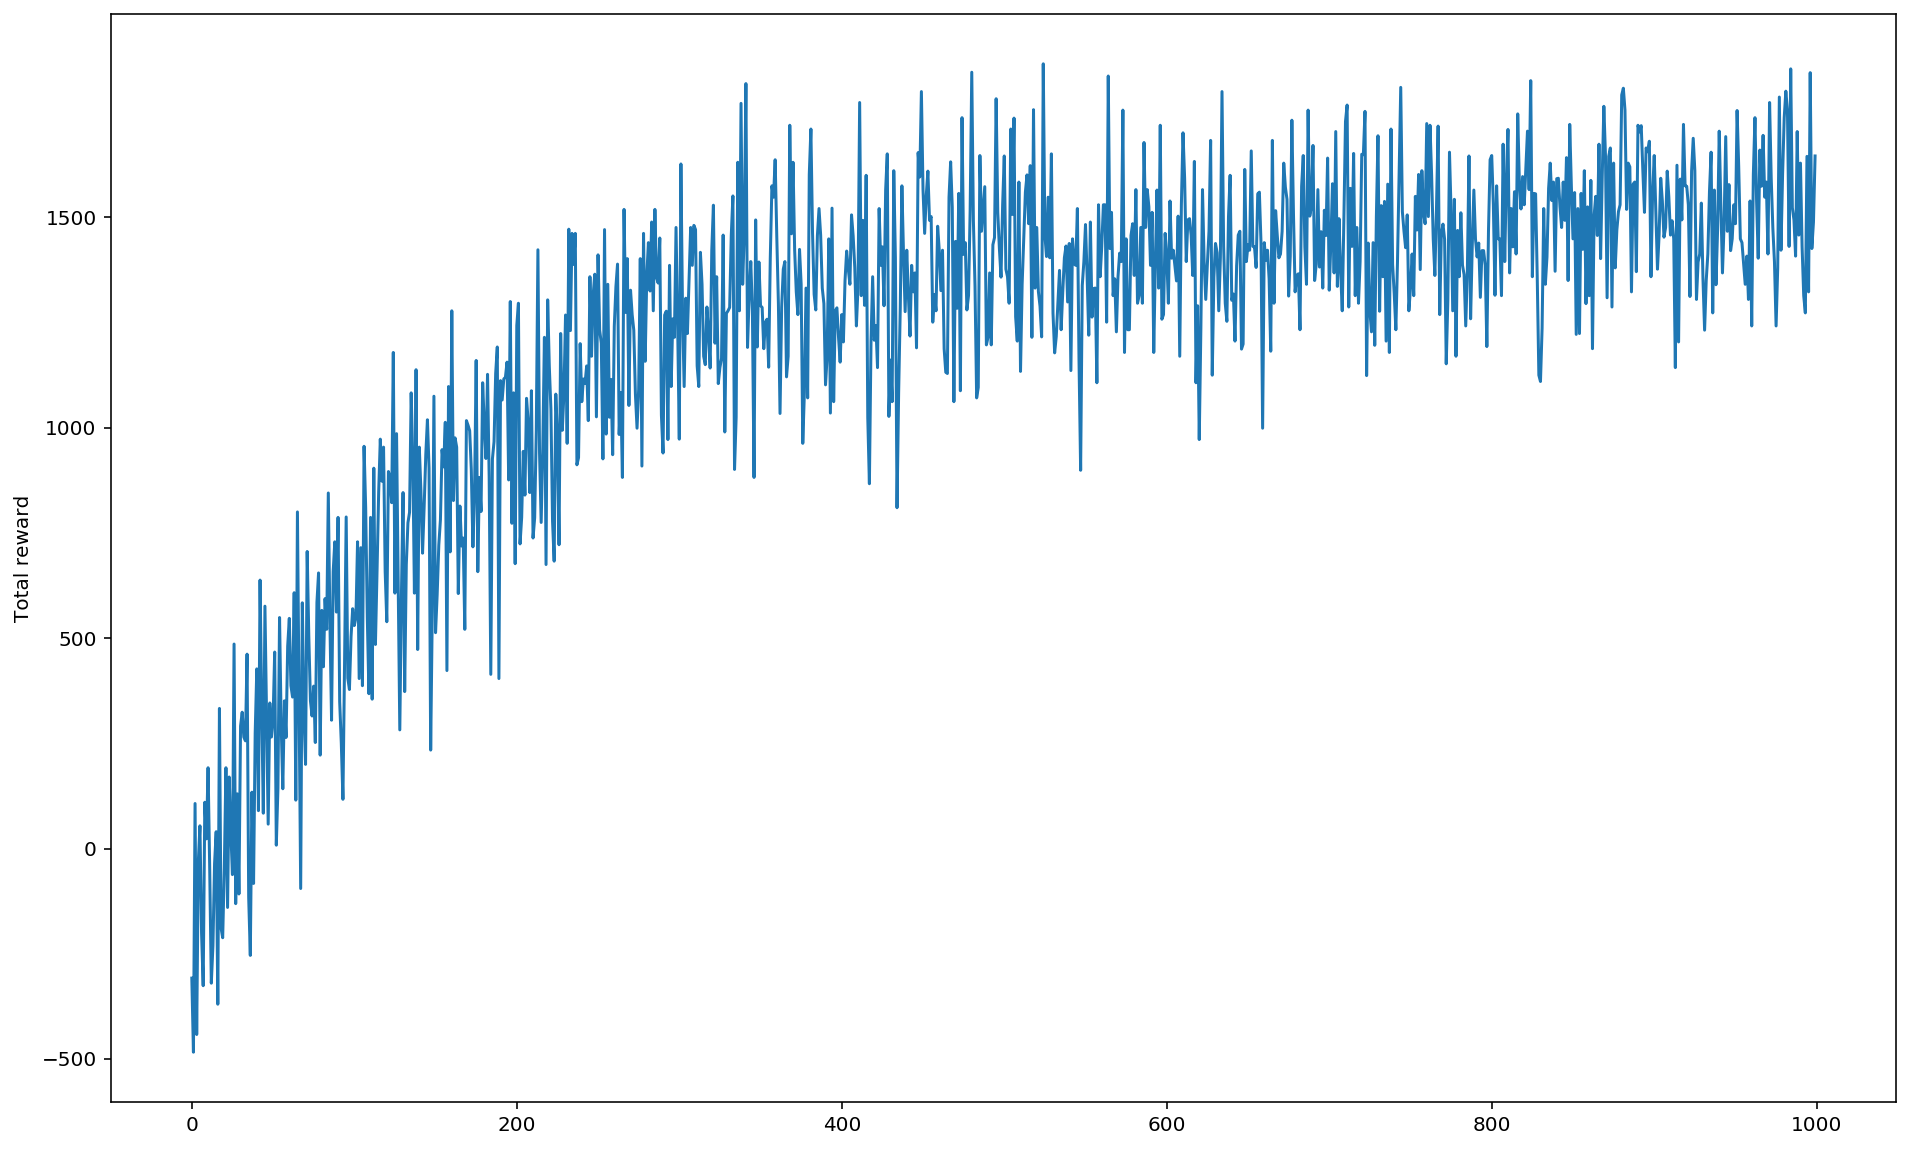

In [19]:
# Plotting total rewards
plt.figure(figsize=(16,10))
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.ylabel("Total reward")
plt.show()

### Tracking Convergence

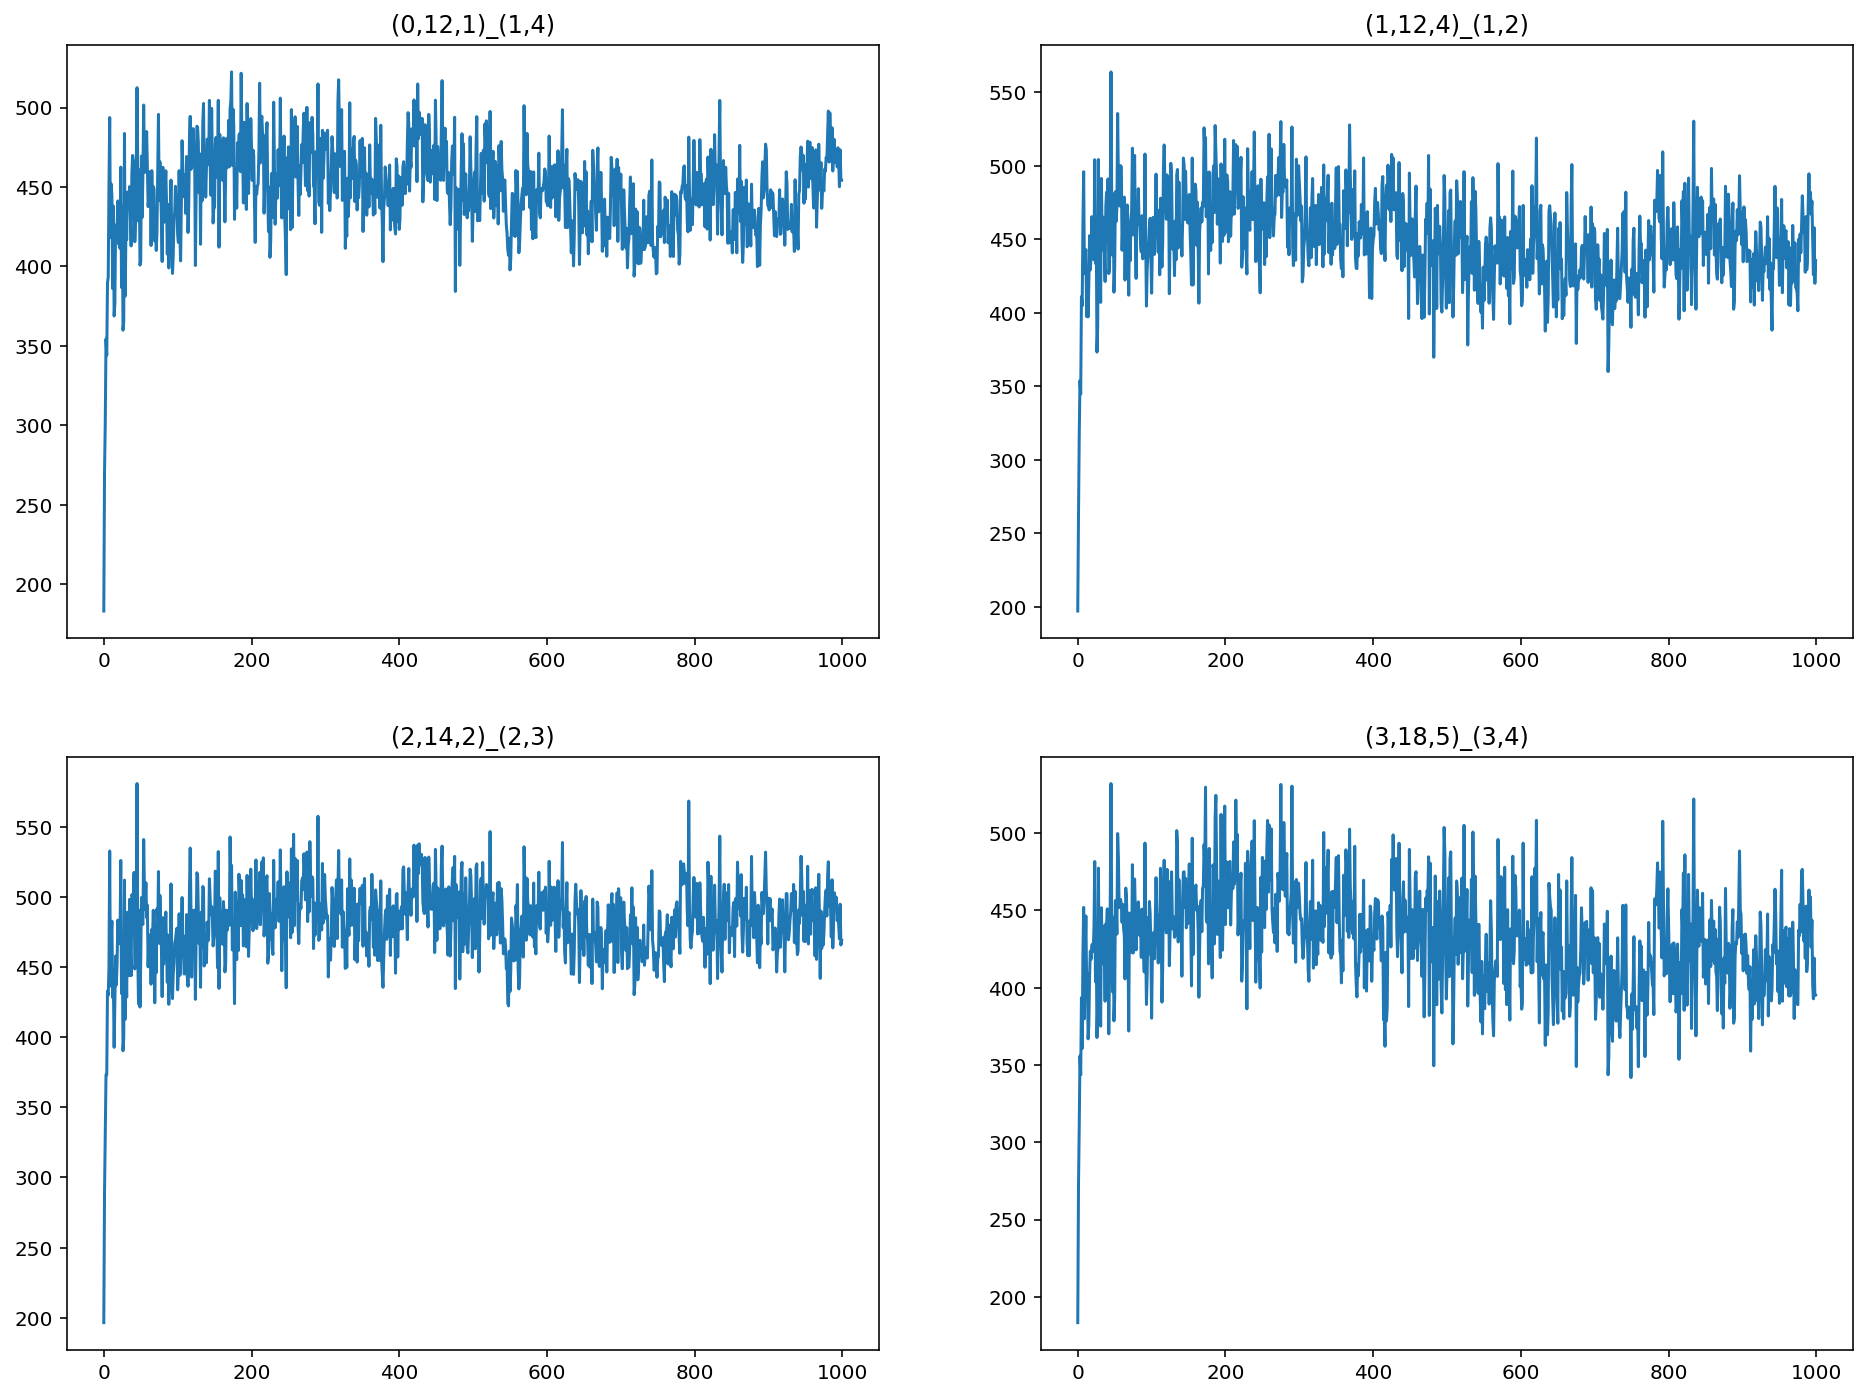

In [20]:
plot_tracked_values(agent.states_track, big=True)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [21]:
epsilon_greedy_policy = EpsilonGreedyPolicy(
    epsilon_max=agent_param.epsilon_max,
    epsilon_min=agent_param.epsilon_min,
    epsilon_decay=agent_param.epsilon_decay)

time = np.arange(0, EPISODES)
epsilon = []
for i in range(0, EPISODES):
    epsilon.append(epsilon_greedy_policy.get_epsilon(i))

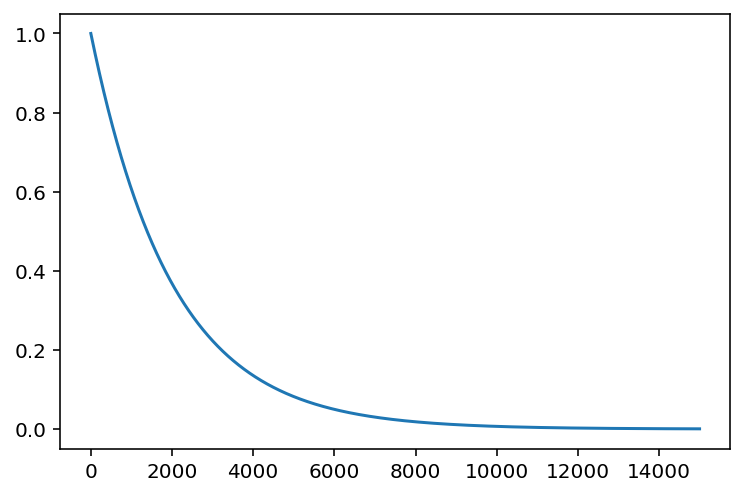

In [22]:
plt.plot(time, epsilon)
plt.show()